## 学习和使用回归分析

* 复习教材第8、9章内容，调试运行相关代码。
* 查阅scikit-learn工具包中回归学习器的相关说明，了解相关函数使用方法。
* 对波士顿房价数据集进行回归分析。

# 回归分析

## 线性回归

目标：给定数据集$D=\{(\boldsymbol{x_1},y_1),(\boldsymbol{x_2},y_2),...,(\boldsymbol{x_m},y_m)\}$ ，其中$\boldsymbol{x_i}=(x_{i1};x_{i2};...x_{id}), \ y_i \in R$，学习一个线性模型以尽可能准确地预测实值输出标记，即学习得到$f(x_i)\approx y_i$

先考虑简单的一元线性回归，目标是求得回归方程 $f(x)=wx_i+b$ 使得 $f(x_i)\approx y_i$ 。 $w$ 称为回归系数，求回归系数的过程就是回归。

我们可以简单地从一定量数据中求得回归方程。假定输入数据存放在矩阵 $\boldsymbol{X}$ 中，回归系数存放在向量 $w$ 中，对于给定的 $X_1$ ，预测结果将会通过 $Y_1 = X_1^T w$ 给出，通过计算预测Y和真实Y之间的差值，选择一个使得误差最小的 $w$ 。比如可以采用平方误差：

$$ \sum\limits_{i=1}^m (y_i - x_i^Tw)^2 $$

用矩阵表示则是 $ (y-\boldsymbol{X}w)^T(y-\boldsymbol{X}w $ 。对 $w$ 求导并令其为零，可以解出最优解（普通最小二乘法，OLS）

$$ \hat{w} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^Ty $$

计算过程中存在求逆运算，所以需要判断逆矩阵是否存在。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) - 1 #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

def standRegres(xArr,yArr):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0.0: # 检查行列式是否为0
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*yMat) #.I 为逆运算
    return ws

In [3]:
xArr,yArr=loadDataSet('./data/ex0.txt')
display(xArr[0:2]) # X0,X1
display(yArr[0:2])

[[1.0, 0.067732], [1.0, 0.42781]]

[3.176513, 3.816464]

In [4]:
ws = standRegres(xArr,yArr)
ws

matrix([[3.00774324],
        [1.69532264]])

得到了回归系数，得到回归方程。y = ws[0] + ws[1] \* X1，可以绘图查看拟合效果

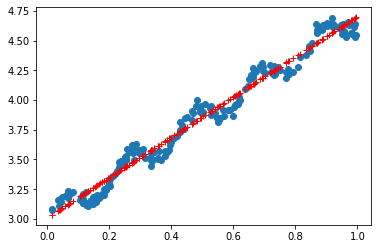

In [5]:
xMat = np.mat(xArr)
yMat = np.mat(yArr)
yHat = xMat*ws

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0])
xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy*ws
ax.plot(xCopy[:,1],yHat,'r+')

除了可视化，也可以使用计算相关系数的方法来评估回归效果。`numpy`自带的`corrcoef()`方法可以计算预测值和真实值的相关性：

In [6]:
np.corrcoef((xMat*ws).T, yMat)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

## 局部加权线性回归LWLR

一般的线性回归容易出现欠拟合，无法发现数据中的一些潜在模式。

局部加权线性回归给待预测点附近的每个点赋予一定的权重，在子集上基于最小均方差进行普通回归（每次回归都需要事先选取出对应的数据子集）。该算法解出的回归系数最优解为：

$$ \hat{w} = (\boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{W}y $$

其中 $\boldsymbol{W}$ 为一个矩阵，为每个数据点赋予权重。

LWLR使用“核”对附近的点赋予更高的权重。最常用的核为高斯核：

$$ w(i,i) = \exp{\left(-\dfrac{(x^{(i)}-x)^2}{2k^2}\right)} $$

In [7]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]     #Xi - X
        weights[j,j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

def lwlrTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

In [8]:
display(lwlr(xArr[0],xArr,yArr,1.0)) # 单点估计
display(lwlr(xArr[0],xArr,yArr,0.001)) # 单点估计

matrix([[3.12204471]])

matrix([[3.20175729]])

In [9]:
%%time
yHat = lwlrTest(xArr, xArr, yArr, 0.003) # 整体估计

CPU times: user 3.08 s, sys: 1.2 s, total: 4.28 s
Wall time: 2.21 s


局部加权线性回归增加了计算量，对每个点做预测时都必须使用整个数据集。

In [10]:
srtInd = xMat[:,1].argsort(0)
xSort = xMat[srtInd][:,0,:]

In [11]:
yHat1 = lwlrTest(xArr, xArr, yArr, 1)
yHat2 = lwlrTest(xArr, xArr, yArr, 0.01)
yHat3 = lwlrTest(xArr, xArr, yArr, 0.003)

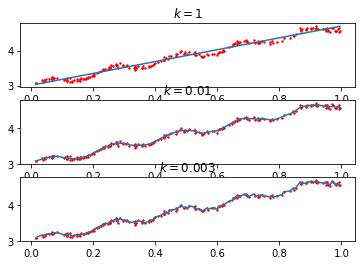

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.set_title('$k=1$')
ax1.plot(xSort[:,1],yHat1[srtInd])
ax1.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0], s=2, c='r')
ax2 = fig.add_subplot(312)
ax2.set_title('$k=0.01$')
ax2.plot(xSort[:,1],yHat2[srtInd])
ax2.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0], s=2, c='r')
ax3 = fig.add_subplot(313)
ax3.set_title('$k=0.003$')
ax3.plot(xSort[:,1],yHat3[srtInd])
ax3.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0], s=2, c='r')

可以观察到k取三种值时回归曲线的拟合情况。k过大可能导致欠拟合，k过小可能导致过拟合。

## 缩减系数

### 岭回归

当特征数大于样本数，即 $X^TX$ 不是满秩矩阵时，求逆运算无法正常进行。此时可以对原式中 $X^TX$ 加上一个 $\lambda I$ 单位矩阵，使得矩阵非奇异。

此时回归参数最优解为

$$ \hat{w}=(X^TX+\lambda I)^{-1}X^Ty $$

岭回归最先用来处理特征数多于样本数的情况，现在也用于在估计中加入偏差，从而得到更好的估计。这里通过引入 $\lambda$ 来限制了所有 $w$ 之和，通过引入该惩罚项，能够减少不重要的参数，这个技术在统计学中也叫做缩减

In [13]:
def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0: # 这里一般是lam设置为0的情况
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws
    
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #to eliminate X0 take mean off of Y
    #regularize X's 对X标准化处理
    xMeans = np.mean(xMat,0)   #calc mean then subtract it off
    xVar = np.var(xMat,0)      #calc variance of Xi then divide by it
    xMat = (xMat - xMeans)/xVar
    numTestPts = 30
    wMat = np.zeros((numTestPts,np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))
        wMat[i,:]=ws.T
    return wMat

调用`ridgeTest()`可以在30个不同的 $\lambda$ 下调用 `ridgeRegres()`方法。可以得到30个不同 $\lambda$ 下得到的回归系数。

In [14]:
abX, abY = loadDataSet('./data/abalone.txt')
ridgeWeights = ridgeTest(abX,abY) 
ridgeWeights.shape

(30, 8)

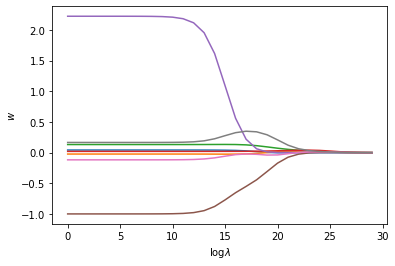

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.xlabel('$\log{\lambda}$')
plt.ylabel('$w$')
plt.show()

可以在图中看出回归系数和 $\log{\lambda}$ 的关系。 $\lambda$ 最小时，可以得到所有系数的原始值（与线性回归一致）；而很大时，系数全部缩减为0。中间部分的某值可以取得最好的预测效果。

### 前向逐步回归

前向逐步回归属于一种贪心算法，每一步都减少误差。一开始所有的权重都设为1，然后每一步所做的决策是对某个权重增加或减少一个很小的值。

算法思路：

> * 数据标准化，使其分布满足0均值和单位方差
> * 在每轮迭代过程中：
>   * 设置当前最小误差lowestError为+∞
>   * 对每个特征：
>     * 增大或缩小：
>       * 改变一个系数得到一个新的 $w$
>       * 计算新 $w$ 下的误差
>       * 如果误差Error小于当前最小误差lowestError：
>         * 设置 $w_{\text{best}}$等于当前的 $w$ 
>   * 将 $w$ 设置为新的$w_{\text{best}}$



In [16]:
def rssError(yArr,yHatArr): #yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()

def regularize(xMat):#regularize by columns
    inMat = xMat.copy()
    inMeans = np.mean(inMat,0)   #calc mean then subtract it off
    inVar = np.var(inMat,0)      #calc variance of Xi then divide by it
    inMat = (inMat - inMeans)/inVar
    return inMat

def stageWise(xArr,yArr,eps=0.01,numIt=100): #eps：每次迭代需要调整的步长； numIt：迭代次数。
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #can also regularize ys but will get smaller coef
    xMat = regularize(xMat)
    m,n = np.shape(xMat)
    returnMat = np.zeros((numIt,n)) 
    ws = np.zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()
    for i in range(numIt):
#         print(ws.T)
        lowestError = np.inf; 
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = rssError(yMat.A,yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:]=ws.T
    return returnMat

In [17]:
stageWise(abX,abY,0.01,200)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [18]:
%%time
stageWise(abX,abY,0.001,5000)

CPU times: user 8.71 s, sys: 3.11 s, total: 11.8 s
Wall time: 6.22 s


array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])

尝试更小的步长和更多的步数后，可以得到一个较好的结果。和最小二乘法进行比较：

In [19]:
%%time
xMat = np.mat(abX); yMat = np.mat(abY).T
xMat = regularize(xMat)
yM = np.mean(yMat,0)
yMat = yMat - yM
weights = standRegres(xMat,yMat.T)
weights.T

CPU times: user 18.9 ms, sys: 11 ms, total: 29.9 ms
Wall time: 17 ms


matrix([[ 0.0430442 , -0.02274163,  0.13214087,  0.02075182,  2.22403814,
         -0.99895312, -0.11725427,  0.16622915]])

可以看到多次迭代后，逐步线性回归算法与常规的最小二乘法效果类似。逐步线性回归能够帮助人们理解现有的模型并作出改进，当构建了一个模型后，可以运行该算法找出重要的特征，这样就有可能及时停止对那些不重要特征的收集。

# 树回归

线性回归的不足：

* 现实问题非线性
* 仅用线性回归难以拟合所有样本（容易过拟合）
* 解决方法
  * 递归切分数据集，使子集适于用线性模型拟合
  * 树结构+回归
  * CART树
  

## CART回归树生成

基本思路：

> * 给定训练数据集 $D=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$ 
>
> * 设回归树将输入空间划分为 $m$ 个单元 $R_1,R_2,...,R_m$ 并且每个单元 $R_m$ 上有一个固定的输出 $C_m$ ，则回归树可表示为
>   $$
  f(x) = \sum\limits_{m=1}^M c_mI \ \ (x\in R_m)
   $$
>
> * 由平方误差 $\sum\limits_{x_i\in m} (y_i-f(x_i))^2$ 最小准则，可知每个单元 $R_m$ 上的最优输出值 $\hat{c}_m = \text{ave}(y_i|x_i \in R_m)$

最小二乘回归树生成算法

> * 输入：训练数据集 $D$ ;
>
> * 输出：回归树 $f(x)$。
>
> * 在训练数据集所在的输入空间中，递归地将每个区域划分为两个子区域并决定每个子区域上的输出值，构建二叉决策树：
>
>   * 选择最优切分变量 $j$ 和切分点 $s$ ，求解
>     $$
     \min\limits_{j,s}\left[\min\limits_{c_1}\sum\limits_{x\in R_1(j,s)}(y_i-c_1)^2 + \min\limits_{c_2}\sum\limits_{x\in R_2(j,s)}(y_i-c_2)^2\right]
     $$
>     遍历变量 $j$ ，对固定的切分变量 $j$ 扫描切分点 $s$ ，选择使式达到最小值的 $(j,s)$ 对。
>
>   * 用选定的 $(j,s)$ 对划分区域并决定相应的输出值：
>     $$
     R_1(j,s) = \{x|x^{(j)} \le s\}, \ R_2(j,s) = \{x|x^{(j)} \gt s\} \\
     \hat{c}_m = \dfrac{1}{N_m} \sum\limits_{x_i \in R_m(j,s)} y_i, \ \ x\in R_m, \ \ m=1,2
     $$
>
>   * 继续对两个子区域调用以上两步，直至满足停止条件。
>
>   * 将输入空间划分为 $M$ 个区域 $R_1, R_2, ..., R_M$ ，生成决策树：
>     $$
     f(x) = \sum\limits_{m=1}^M c_mI \ \ (x\in R_m)
     $$

In [20]:
# 树的数据结构

class treeNode():
    def __init__(self, feat, val, right, left):
        featureToSplitOn = feat
        valueOfSplit = val
        rightBranch = right
        leftBranch = left

In [21]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))  # 转化为float类型
        dataMat.append(fltLine)
    return dataMat

def binSplitDataSet(dataSet, feature, value): # 函数说明:根据特征切分数据集合
    mat0 = dataSet[np.nonzero(dataSet[:, feature] > value)[0], :]
    mat1 = dataSet[np.nonzero(dataSet[:, feature] <= value)[0], :]
    return mat0, mat1

def regLeaf(dataSet): # 函数说明:生成叶结点
    return np.mean(dataSet[:, -1])

def regErr(dataSet): # 函数说明:误差估计函数
    return np.var(dataSet[:, -1]) * np.shape(dataSet)[0]

# 函数说明:找到数据的最佳二元切分方式函数
"""
Parameters:
    dataSet - 数据集合
    leafType - 生成叶结点
    regErr - 误差估计函数
    ops - 用户定义的参数构成的元组
"""
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    import types
    # tolS允许的误差下降值,tolN切分的最少样本数
    ## 用于控制函数的停止时机
    tolS = ops[0]; tolN = ops[1]
    # 如果当前所有值相等,则退出。(根据set的特性)
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1:
        return None, leafType(dataSet)
    # 统计数据集合的行m和列n
    m, n = np.shape(dataSet)
    # 默认最后一个特征为最佳切分特征,计算其误差估计
    S = errType(dataSet)
    # 分别为最佳误差,最佳特征切分的索引值,最佳特征值
    bestS = float('inf');
    bestIndex = 0;
    bestValue = 0
    # 遍历所有特征列
    for featIndex in range(n - 1):
        # 遍历所有特征值
        for splitVal in set(dataSet[:, featIndex].T.A.tolist()[0]):
            # 根据特征和特征值切分数据集
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            # 如果数据少于tolN,则退出
            if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN): continue
            # 计算误差估计
            newS = errType(mat0) + errType(mat1)
            # 如果误差估计更小,则更新特征索引值和特征值
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    # 如果误差减少不大则退出
    if (S - bestS) < tolS:
        return None, leafType(dataSet)
    # 根据最佳的切分特征和特征值切分数据集合
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    # 如果切分出的数据集很小则退出
    if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):
        return None, leafType(dataSet)
    # 返回最佳切分特征和特征值
    return bestIndex, bestValue

# 函数说明:树构建函数
"""
Parameters:
    dataSet - 数据集合
    leafType - 建立叶结点的函数
    errType - 误差计算函数
    ops - 包含树构建所有其他参数的元组
"""
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    # 选择最佳切分特征和特征值
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    # r如果没有特征,则返回特征值
    if feat == None: return val
    # 回归树
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    # 分成左数据集和右数据集
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    # 创建左子树和右子树
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [22]:
myDat = loadDataSet('./data/ex00.txt')
myMat = np.mat(myDat)
createTree(myMat)

{'spInd': 0,
 'spVal': 0.48813,
 'left': 1.0180967672413792,
 'right': -0.04465028571428572}

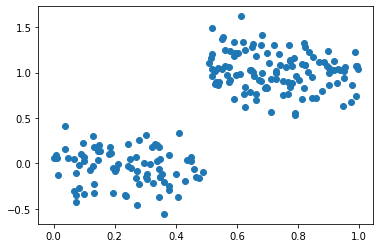

In [23]:
plt.scatter(np.array(myDat)[:,0],np.array(myDat)[:,1])

上图为原数据分布情况，我们生成的树正好包含2个叶节点。

{'spInd': 0, 'spVal': 0.48813, 'left': 1.0180967672413792, 'right': -0.04465028571428572}


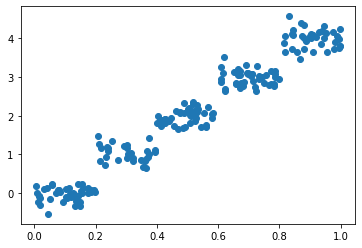

In [24]:
myDat1 = loadDataSet('./data/ex01.txt')
myMat1 = np.mat(myDat)
print(createTree(myMat1))
plt.scatter(np.array(myDat1)[:,1],np.array(myDat1)[:,2])

另取数据，从图看有五个簇，而生成的树恰好也有五个叶子节点。

## CART树剪枝

基本方法：

* 从决策树底端开始不断剪枝直至根节点，形成子树序列
* 通过交叉验证法测试子树序列选取最优子树

### 预剪枝

树构建算法对输入的参数`tolS` 和`tolN` 非常敏感。可以测试

In [25]:
print(createTree(myMat,ops=(0,1))) ## 几乎为每个样本都构建了一个叶子节点

{'spInd': 0, 'spVal': 0.48813, 'left': {'spInd': 0, 'spVal': 0.620599, 'left': {'spInd': 0, 'spVal': 0.625336, 'left': {'spInd': 0, 'spVal': 0.625791, 'left': {'spInd': 0, 'spVal': 0.643601, 'left': {'spInd': 0, 'spVal': 0.651376, 'left': {'spInd': 0, 'spVal': 0.6632, 'left': {'spInd': 0, 'spVal': 0.683921, 'left': {'spInd': 0, 'spVal': 0.819823, 'left': {'spInd': 0, 'spVal': 0.837522, 'left': {'spInd': 0, 'spVal': 0.846455, 'left': {'spInd': 0, 'spVal': 0.919384, 'left': {'spInd': 0, 'spVal': 0.976414, 'left': {'spInd': 0, 'spVal': 0.985425, 'left': {'spInd': 0, 'spVal': 0.989888, 'left': {'spInd': 0, 'spVal': 0.993349, 'left': 1.035533, 'right': 1.077553}, 'right': {'spInd': 0, 'spVal': 0.988852, 'left': 0.744207, 'right': 1.069062}}, 'right': 1.227946}, 'right': {'spInd': 0, 'spVal': 0.953112, 'left': {'spInd': 0, 'spVal': 0.975022, 'left': 0.862911, 'right': 0.673579}, 'right': {'spInd': 0, 'spVal': 0.948268, 'left': {'spInd': 0, 'spVal': 0.951949, 'left': 1.06469, 'right': {'spInd

{'spInd': 0, 'spVal': 0.499171, 'left': {'spInd': 0, 'spVal': 0.729397, 'left': {'spInd': 0, 'spVal': 0.952833, 'left': {'spInd': 0, 'spVal': 0.958512, 'left': 105.24862350000001, 'right': 112.42895575000001}, 'right': {'spInd': 0, 'spVal': 0.759504, 'left': {'spInd': 0, 'spVal': 0.790312, 'left': {'spInd': 0, 'spVal': 0.833026, 'left': {'spInd': 0, 'spVal': 0.944221, 'left': 87.3103875, 'right': {'spInd': 0, 'spVal': 0.85497, 'left': {'spInd': 0, 'spVal': 0.910975, 'left': 96.452867, 'right': {'spInd': 0, 'spVal': 0.892999, 'left': 104.825409, 'right': {'spInd': 0, 'spVal': 0.872883, 'left': 95.181793, 'right': 102.25234449999999}}}, 'right': 95.27584316666666}}, 'right': {'spInd': 0, 'spVal': 0.811602, 'left': 81.110152, 'right': 88.78449880000001}}, 'right': 102.35780185714285}, 'right': 78.08564325}}, 'right': {'spInd': 0, 'spVal': 0.640515, 'left': {'spInd': 0, 'spVal': 0.666452, 'left': {'spInd': 0, 'spVal': 0.706961, 'left': 114.554706, 'right': {'spInd': 0, 'spVal': 0.698472, '

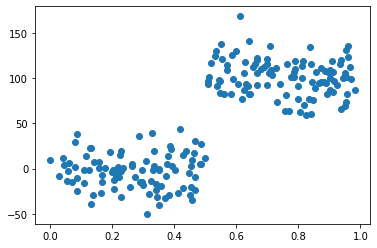

In [26]:
myDat2 = loadDataSet('./data/ex2.txt')
myMat2 = np.mat(myDat2)
print(createTree(myMat2))
plt.scatter(np.array(myMat2)[:,0],np.array(myMat2)[:,1])

`ex2.txt`的数据相比`ex0.txt`只是数量级发生了变化。而生成的树却有很多叶节点。原因在于停止条件`tolS`对误差的数量级十分敏感。如果在参数中对误差容忍度取平方值，可以得到仅有两个叶节点组成的树：

In [27]:
createTree(myMat2, ops=(10000,4))

{'spInd': 0,
 'spVal': 0.499171,
 'left': 101.35815937735848,
 'right': -2.637719329787234}

然而，不断修改停止条件来得到“合理”结果并不是很好的方法，大多时候我们不确定要得到什么样的结果。

### 后剪枝

简化算法：

> *  基于已有的树切分测试数据：
>    * 如果存在任一子集是一棵树，则在该子集递归剪枝过程
>    * 计算将当前两个叶节点合并后的误差
>    * 计算不合并的误差
>    * 如果合并会降低误差的话，就将叶节点合并

In [28]:
def isTree(obj):
    import types
    return (type(obj).__name__ == 'dict')

def getMean(tree): # 函数说明:对树进行塌陷处理(即返回树平均值)
    if isTree(tree['right']): tree['right'] = getMean(tree['right'])
    if isTree(tree['left']): tree['left'] = getMean(tree['left'])
    return (tree['left'] + tree['right']) / 2.0

def prune(tree, testData):
    #如果测试集为空,则对树进行塌陷处理
    if np.shape(testData)[0] == 0: return getMean(tree)
    #如果有左子树或者右子树,则切分数据集
    if (isTree(tree['right']) or isTree(tree['left'])):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    #处理左子树(剪枝)
    if isTree(tree['left']): tree['left'] = prune(tree['left'], lSet)
    #处理右子树(剪枝)
    if isTree(tree['right']): tree['right'] =  prune(tree['right'], rSet)
    #如果当前结点的左右结点为叶结点
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        #计算没有合并的误差
        errorNoMerge = np.sum(np.power(lSet[:,-1] - tree['left'],2)) + np.sum(np.power(rSet[:,-1] - tree['right'],2))
        #计算合并的均值
        treeMean = (tree['left'] + tree['right']) / 2.0
        #计算合并的误差
        errorMerge = np.sum(np.power(testData[:,-1] - treeMean, 2))
        #如果合并的误差小于没有合并的误差,则合并
        if errorMerge < errorNoMerge:
            print('merging')
            return treeMean
        else: return tree
    else: return tree

In [29]:
myTree = createTree(myMat2, ops=(0,1))
myDat2Test = loadDataSet('./data/ex2test.txt')
myMat2Test = np.mat(myDat2Test)
print(prune(myTree, myMat2Test))

merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
{'spInd': 0, 'spVal': 0.499171, 'left': {'spInd': 0, 'spVal': 0.729397, 'left': {'spInd': 0, 'spVal': 0.952833, 'left': {'spInd': 0, 'spVal': 0.965969, 'left': 92.5239915, 'right': {'spInd': 0, 'spVal': 0.956951, 'left': {'spInd': 0, 'spVal': 0.958512, 'left': {'spInd': 0, 'spVal': 0.960398, 'left': 112.386764, 'right': 123.559747}, 'right': 135.837013}, 'right': 111.2013225}}, 'right': {'spInd': 0, 'spVal': 0.759504, 'left': {'spInd': 0, 'spVal': 0.763328, 'left': {'spInd': 0, 'spVal': 0.769043, 'left': {'spInd': 0, 'spVal': 0.790312, 'left': {'spInd': 0, 'spVal': 0.806158, 'left': {'spInd': 0, 'spVal': 0.815215, 'left': {'spInd': 0, 'spVa

大量的节点被剪枝掉了，但是叶子节点还剩下了很多，说明后剪枝未必有预剪枝有效。一般可以同时采用两种剪枝技术来寻求最佳模型。

## 模型树

用树来对数据建模，除了把叶节点简单地设定为常数值之外，还有一种方法是把叶节点设定为分段线性函数。

In [30]:
def linearSolve(dataSet):   #helper function used in two places
    m,n = np.shape(dataSet)
    X = np.mat(np.ones((m,n))); Y = np.mat(np.ones((m,1)))#create a copy of data with 1 in 0th postion
    X[:,1:n] = dataSet[:,0:n-1]; Y = dataSet[:,-1]#and strip out Y
    xTx = X.T*X
    if np.linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws,X,Y

def modelLeaf(dataSet):#create linear model and return coeficients
    ws,X,Y = linearSolve(dataSet)
    return ws

def modelErr(dataSet):
    ws,X,Y = linearSolve(dataSet)
    yHat = X * ws
    return np.sum(np.power(Y - yHat,2))

对原来的`createTree()`方法中，修改`leafType`和`errType`参数，即可

{'spInd': 0,
 'spVal': 0.285477,
 'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]),
 'right': matrix([[3.46877936],
         [1.18521743]])}

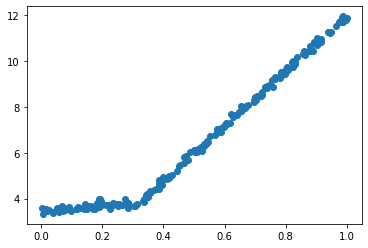

In [31]:
myMat2 = np.mat(loadDataSet('./data/exp2.txt'))
display(createTree(myMat2, leafType=modelLeaf, errType=modelErr, ops=(1,10)))
plt.scatter(np.array(myMat2)[:,0],np.array(myMat2)[:,1])

程序以0.285477为界创建了两个模型，与数据的分段类似。

生成的两个线性模型也与真实模型非常接近：

| 分段 | 回归方程 | 实际方程 |
| -- | ------------ | ------------ |
| 0~0.3 | $y=3.468+1.1852 x$ | $y=3.5+1.0x+高斯噪声$ |
| 0.3~1 | $y=0.00169+11.96x$ | $y=0.0+12.0x+高斯噪声$ |